## 导入需要使用的库

In [2]:
from PIL import Image as im
from tqdm import tqdm_notebook as tn
import numpy as np
import torch as t
import matplotlib.pyplot as plt

## 进行照片读入

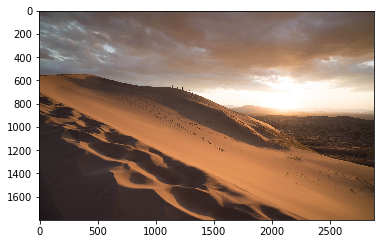

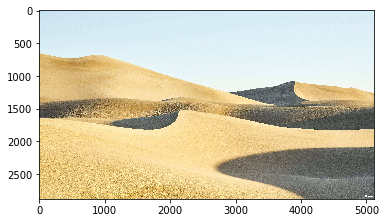

In [3]:
l1 = im.open('dessert1.jpg')
l2 = im.open('dessert2.jpg')
plt.imshow(l1)
plt.show()
plt.imshow(l2)
plt.show()

## 定义颜色空间转换函数

In [4]:
Transfer_matrix = np.array([[ 65.481, 128.553, 24.966],[-37.797, -74.203, 112.0],[112.0, -93.786, -18.214]])
Transfer_matrix_inv = np.linalg.inv(Transfer_matrix)
offset = np.array([16, 128, 128])
 
def rgb2ycbcr(rgb_img):
    ycbcr_img = np.zeros(rgb_img.shape)
    for x in range(rgb_img.shape[0]):
        for y in range(rgb_img.shape[1]):
            ycbcr_img[x, y, :] = np.round(np.dot(Transfer_matrix, rgb_img[x, y, :] * 1.0 / 255) + offset)
    return ycbcr_img
def ycbcr2rgb(ycbcr_img):
    rgb_img = np.zeros(ycbcr_img.shape, dtype=np.uint8)
    for x in range(ycbcr_img.shape[0]):
        for y in range(ycbcr_img.shape[1]):
            [r, g, b] = ycbcr_img[x,y,:]
            rgb_img[x, y, :] = np.maximum(0, np.minimum(255, np.round(np.dot(Transfer_matrix_inv, ycbcr_img[x, y, :] - offset) * 255.0)))
    return rgb_img

### 进行图片数据预处理

In [5]:
def compress (img,num):
    a1,a2 = img.size
    img = img.resize((int(a1/num),int(a2/num)))
    return img

In [6]:
#print(l1.shape,l2.shape)
l1_array = compress(l1,4)
l2_array = compress(l2,4)
l1_array = np.array(l1_array)
l2_array = np.array(l2_array)
print(l1_array.shape,l2_array.shape)
# l1_array = rgb2ycbcr(l1_array)
# l2_array = rgb2ycbcr(l2_array)
l1_array = l1_array.astype(np.int)
l2_array = l2_array.astype(np.int)
# plt.imshow(l1)
# plt.show()
# plt.imshow(l2)
# plt.show()

(450, 720, 3) (720, 1280, 3)


## 直方图特例化

In [7]:
def cdf (array):
    a = array.shape[0]
    sum_array = np.zeros(a)
    for num in range(a):
        if num == 0:
            sum_array[0] = array[0]
        else:
            sum_array[num] = array[num] + sum_array[num-1]
    return sum_array 

In [8]:
def statistics(array):
    x,y = array.shape
    result = np.zeros(256)
    for i in range(0,x-1):
        for j in range (0,y-1):
            result[array[i-1][j-1]] += 1
    result = result/result.sum()
    return result

In [9]:
def map_sp(cdf1,cdf2):
    x = cdf1.shape[0]
    #print(x)
    map_array = 255 * np.ones(x)
    for i in range(0,x):
          for j in range(0,x):
            if cdf2[j] >= cdf1[i]:
                map_array[i] = j
                break;
    #print(map_array)
    return map_array

In [10]:
def map_special_3d(array,cdf_target,cdf_pic):
    x_sp,y_sp,z_sp = array.shape
    l_mapsp = np.zeros((x_sp,y_sp,z_sp))
    for k in range(z_sp):
        map_rel = map_sp(cdf_target[k-1,:],cdf_pic[k-1,:])
        #print(map_rel)
        for i in range(x_sp):
            for j in range(y_sp):
                l_mapsp[i,j,k] = map_rel[array[i,j,k]]
   # l_mapsp = np.int(l_mapsp)
    return l_mapsp

In [11]:
def cdf_3d(array):
    array_cdf = np.zeros((3,256))
    for i in range(3):
        array_cdf[i,:] = cdf(statistics(array[:,:,i]))
    return array_cdf

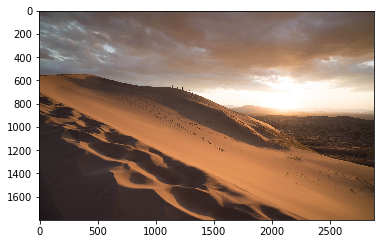

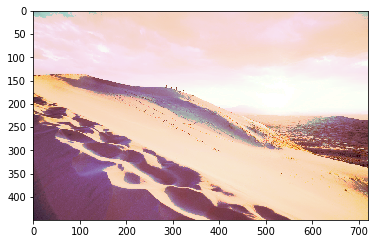

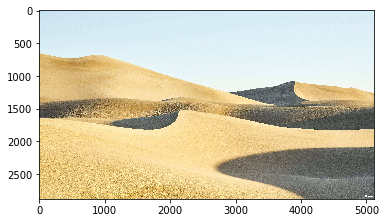

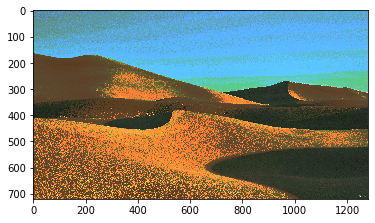

In [14]:
CDF1 = cdf_3d(l1_array)
CDF2 = cdf_3d(l2_array)
l1_array_map = map_special_3d(l1_array,CDF1,CDF2)
l2_array_map = map_special_3d(l2_array,CDF2,CDF1)
#l1_map = ycbcr2rgb(l1_array_map)
#l2_map = ycbcr2rgb(l2_array_map)
#l1_map = l1_map.astype(np.int)
#l2_map = l2_map.astype(np.int)
l1_map = np.uint8(l1_array_map)
im_l1_map = im.fromarray(l1_map)
l2_map = np.uint8(l2_array_map)
im_l2_map = im.fromarray(l2_map)
plt.imshow(l1)
plt.show()
plt.imshow(im_l1_map)
plt.show()
plt.imshow(l2)
plt.show()
plt.imshow(im_l2_map)
plt.show()
im_l1_map.show()